# Landscape-species inference

The central focus of landscape ecology is exploring the relationship between the spatial pattern of landscapes and the ecological processes that occur on them <cite data-cite="hesselbarth2024computational"/>.

This notebook shows how the `FocalAnalysis` class can be used to perform landscape-species inference following the focal site multi-scale study framework <cite data-cite="brennen2002focal"/>. As an example use case, we will explore the relationship between bird species richness collected at multiple sites in Zurich - data from <cite data-cite="casanelles2021applying"/> - and the spatial patterns of the landscape surrounding each site.

*Note that the approach of this analysis is essentially the same as the [`MultiScaleAnalysis` class draft of pylandstats](https://github.com/martibosch/pylandstats-notebooks/blob/main/notebooks/06-multiscale-analysis.ipynb). It is likely that in the near future many of the functionalities of the `MultiScaleAnalysis` (and also `SpatialSignatureAnalysis`) class disappear from the pylandstats code base and are instead implemented in focalpy (and thus imported in pylandstats).*

We will first import the required libraries and define some utility functions for plotting.

In [ ]:
import warnings

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn import ensemble, feature_selection, linear_model, preprocessing
from sklearn.model_selection import cross_val_score

import focalpy


def plot_da_and_gdf(da, gdf, column, *, ax=None, cmap="coolwarm", vmin=None, vmax=None):
    """Plot a raster data array and a geo-data frame with the same color scale."""
    if ax is None:
        _, ax = plt.subplots()
    if isinstance(column, str):
        column_data = gdf[column]
    else:
        column_data = column
    if vmin is None:
        vmin = min(da.min().item(), column_data.min())
    if vmax is None:
        vmax = max(da.max().item(), column_data.max())
    da.plot(ax=ax, alpha=0.7, vmin=vmin, vmax=vmax, cmap=cmap)
    gdf.plot(column_data, ax=ax, edgecolor="k", vmin=vmin, vmax=vmax, cmap=cmap)
    cx.add_basemap(ax, crs=gdf.crs)
    return ax

In [ ]:
# spatial predictors
buildings_filepath = "data/buildings.gpkg"
lulc_filepath = "data/lulc.tif"
tree_canopy_filepath = "data/tree-canopy.tif"

# green spaces (5), meadows/pastures (8) and forests (10)
lulc_classes = [5, 8, 10]
class_metrics = ["proportion_of_landscape"]
landscape_metrics = ["shannon_diversity_index"]

# response
species_richness_filepath = "data/bird-richness.gpkg"
y_col = "n.species"  # species richness

# scales
buffer_dists = [250, 500, 750, 1000]  # in meters

# target area (for region-wide prediction/extrapolation)
study_area_filepath = "data/study-area.gpkg"
grid_res = 500

# viz
figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]

Let us start by plotting the target variable, i.e., the number of bird species recorded at each site:

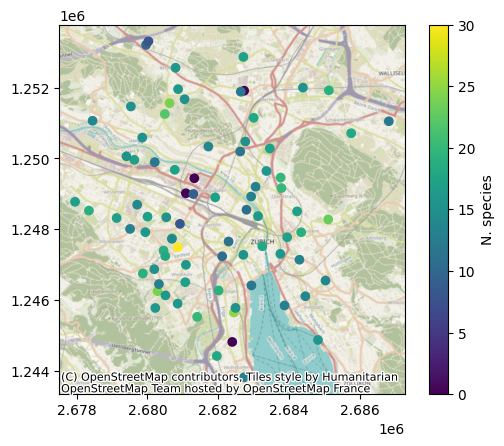

In [ ]:
bird_gdf = gpd.read_file(species_richness_filepath)
# bird_gdf.head()

ax = bird_gdf.plot(y_col, legend=True, legend_kwds={"label": "N. species"})
cx.add_basemap(ax, crs=bird_gdf.crs)

Since the analysis is performed in an urban landsape - which tend to have greater spatial heterogeneity <cite data-cite="band2005heterogeneity"/>, we are using a version of the [Swiss Land Statistics (SLS) datasets from the Swiss Federal Statistical Office](https://www.bfs.admin.ch/bfs/en/home/services/geostat/swiss-federal-statistics-geodata/land-use-cover-suitability/swiss-land-use-statistics.html) whose resolution has been downscaled from the original 100 m to 25 m - see <cite data-cite="giuliani2022downscaling"/> for more details on the methods used. In order to simplify the analysis, we will use the aggregated 17-code LULC scheme from the [NOAS04 nomenclature of the SLS datasets (link in French)](https://www.bfs.admin.ch/bfs/fr/home/statistiques/espace-environnement/nomenclatures/arealstatistik.html).

Following the variables defined above, we will instantiate a `FocalAnalysis` with the following multi-scale spatial predictors: the proportion of landscape covered the green spaces, meadows/pastures and forests as well as the Shannon diversity index (SHDI), which reflects the relative abundance of each LULC class:

In [ ]:
fa = focalpy.FocalAnalysis(
    lulc_filepath,
    bird_gdf,
    buffer_dists,
    "compute_landscape_metrics",
    feature_methods_kwargs=dict(
        class_metrics=class_metrics,
        landscape_metrics=landscape_metrics,
        classes=lulc_classes,
    ),
)

[########################################] | 100% Completed | 726.62 ms
[########################################] | 100% Completed | 1.35 sms
[########################################] | 100% Completed | 205.63 ms
[########################################] | 100% Completed | 308.31 ms
[########################################] | 100% Completed | 204.27 ms
[########################################] | 100% Completed | 319.61 ms
[########################################] | 100% Completed | 203.13 ms
[########################################] | 100% Completed | 317.71 ms


The requested features will be stored as the `features_df` attribute:

In [ ]:
fa.features_df.head()

,proportion_of_landscape_5_250,proportion_of_landscape_5_500,proportion_of_landscape_5_750,proportion_of_landscape_5_1000,proportion_of_landscape_8_250,proportion_of_landscape_8_500,proportion_of_landscape_8_750,proportion_of_landscape_8_1000,proportion_of_landscape_10_250,proportion_of_landscape_10_500,proportion_of_landscape_10_750,proportion_of_landscape_10_1000,shannon_diversity_index_250,shannon_diversity_index_500,shannon_diversity_index_750,shannon_diversity_index_1000
zone,,,,,,,,,,,,,,,,
0,0.000000,1.037510,1.239377,3.189793,0.000000,0.000000,0.000000,0.737640,0.0,0.000000,0.000000,0.338915,0.715564,0.868716,0.896390,1.054748
1,0.000000,0.000000,2.547771,3.702966,0.634921,3.505976,3.326256,2.130201,0.0,7.649402,14.543524,18.893092,0.800883,1.140386,1.363838,1.422790
2,0.000000,0.000000,1.204392,6.135458,0.000000,0.000000,2.019129,1.852590,0.0,0.000000,1.487779,6.752988,0.625197,0.704713,0.952338,1.262781
3,18.910256,19.329073,15.313719,10.001992,0.000000,4.392971,4.253811,3.646145,0.0,1.038339,10.173697,16.796175,1.111966,1.326478,1.540855,1.573991
4,12.779553,23.248408,16.967765,11.080112,0.000000,0.477707,3.719447,4.184934,0.0,0.079618,2.833865,10.721403,0.959092,1.150802,1.423296,1.526619


We can get a first idea of the relationship between the spatial predictors and our target variable by inspecting the weights of a linear regression model estimated using the ordinary least squares (OLS) class of statsmodels:

In [ ]:
X_df = fa.features_df
y_ser = bird_gdf[y_col]

results = sm.OLS(y_ser, sm.add_constant(X_df)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              n.species   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     1.848
Date:                Wed, 26 Nov 2025   Prob (F-statistic):             0.0430
Time:                        13:40:47   Log-Likelihood:                -234.91
No. Observations:                  82   AIC:                             503.8
Df Residuals:                      65   BIC:                             544.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

At first glance, the results suggest that the only significant effect ($p < 0.05$) is found for the SHDI at the 250 m scale. However the condition number is very high, which suggests that our spatial predictors are highly correlated - which is a well known issue of landscape metrics <cite data-cite="riitters2019pattern">. More broadly, collinearity of spatial predictors is very common when using statistical methods to study ecological phenomena and can lead to the erroneous identification of relevant predictors in the regression model (e.g., through confounding) <cite data-cite="dormann2013collinearity">. In this example, collinearity is further exacerbated by the fact that the same predictors are computed at multiple scales.

## Collinearity, scale of effect and selection of spatial predictors

The scale at which the spatial predictors are computed can have a strong influence on the inferred landscape-species relationships <cite data-cite="jackson2015ecologists"/>. Since the appropriate scales may be unknown to the researcher before the study, the spatial predictors are commonly measured at multiple scales to then select the scale that yields the strongest landscape-species relationship, namely the "scale of effect" <cite data-cite="jackson2012size">. We can use the `scale_eval_ser` function to evaluate the strength of the relationship at each scale:

In [ ]:
focalpy.scale_eval_ser(X_df, y_ser)

1000    0.182204
250     0.066968
500     0.092940
750     0.141639
Name: rsquared, dtype: float64

which suggests that the strongest effects occur when using focal buffers of a 1000 m radius. By default, the scale evaluation will be based on the coefficient of determination (R$^2$) of an ordinary least squares linear regression model. However, it is possible to use the `model` keyword argument to customize the criteria by providing any model from `statsmodels` or a function name of a statistical test from `scipy.stats` such as `"spearmanr"`. Additionally, it is also possible to determine the scale of effect for each feature separately by setting the `how` keyword argument to `"individual"` (see an example of this in the *land use regression notebook*).

In order to get the list of features at the scale of effect (based on the evaluation shown above), we can use the `scale_of_effect_features`, which will return the column names:

In [ ]:
soe_features = focalpy.scale_of_effect_features(X_df, y_ser)
soe_features

Index(['proportion_of_landscape_5_1000', 'proportion_of_landscape_8_1000',
       'proportion_of_landscape_10_1000', 'shannon_diversity_index_1000'],
      dtype='object')

We can now use this to perform again our regression using only the features at the scale of effect:

In [ ]:
X_soe_df = fa.features_df[soe_features]

results = sm.OLS(y_ser, sm.add_constant(X_soe_df)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              n.species   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     4.289
Date:                Wed, 26 Nov 2025   Prob (F-statistic):            0.00347
Time:                        13:42:38   Log-Likelihood:                -242.04
No. Observations:                  82   AIC:                             494.1
Df Residuals:                      77   BIC:                             506.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

We can see that this notably decreases our condition number (which is nonetheless still very high) but also at the expense of a decreased R$^2$. At the same time, at this scale (1000 m) all the spatial predictors seem to have a significant effect except the proportion of meadows/pastures.

Note that besides the scale of effect, we can use any other method to select spatial predictors, e.g., methods designed for landscape metrics <cite data-cite="schindler2015performance" /> or filters, wrappers and embedded feature selection methods commonly used in machine learning models <cite data-cite="effrosynidis2021evaluation" />. Given the pedagogical purposes of this example, we just show here how a sequential feature selector from scikit-learn can be used:

In [ ]:
sfs_model = linear_model.LinearRegression()
sfs = feature_selection.SequentialFeatureSelector(sfs_model, n_features_to_select=4)
sfs_features = sfs.fit(X_df, y_ser).get_feature_names_out()
X_sfs_df = fa.features_df[sfs_features]

results = sm.OLS(y_ser, sm.add_constant(X_sfs_df)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              n.species   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.161
Date:                Wed, 26 Nov 2025   Prob (F-statistic):              0.335
Time:                        14:08:15   Log-Likelihood:                -247.89
No. Observations:                  82   AIC:                             505.8
Df Residuals:                      77   BIC:                             517.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

While the sequential feature selection seems to successfully address the collinearity issue, the statistical strength is also vastly reduced.

## Spatial extrapolation

A key objective of the focal analysis design is to spatially extrapolate the inferred landscape-species relationships to a target study area. To that end, given a fitted scikit-learn model, we can use the `predict_raster` function by providing a vector data source defining the target area as well as the desired grid resolution:

[########################################] | 100% Completed | 4.68 sms
[########################################] | 100% Completed | 2.44 sms
[########################################] | 100% Completed | 2.09 sms
[########################################] | 100% Completed | 3.61 sms
[########################################] | 100% Completed | 2.86 sms
[########################################] | 100% Completed | 3.97 sms
[########################################] | 100% Completed | 2.85 sms
[########################################] | 100% Completed | 3.57 sms


<Axes: xlabel='x', ylabel='y'>

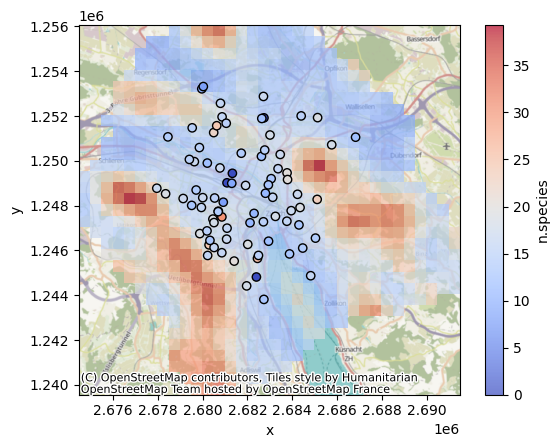

In [ ]:
model_class = linear_model.LinearRegression
model = model_class().fit(X_soe_df, y_ser)
# ax = scatterplot_obs_pred(
#     model,
#     X_soe_df,
#     y_ser,
# )
with warnings.catch_warnings():
    # ignore pylandstats warning when computing entropy-based metrics in landscapes with
    # only one LULC class
    warnings.simplefilter("ignore")
    pred_da = fa.predict_raster(
        model,
        study_area_filepath,
        grid_res,
        features=soe_features,
        pred_label=y_ser.name,
    )
plot_da_and_gdf(pred_da, bird_gdf, y_ser)

## Using fine-grained spatial predictors (buildings and tree canopy)

As noted above, conventional LULC categorical schemes designed for national-scale maps are often too coarse and thus unable to represent the diversity of habitats provided by urban green spaces <cite data-cite="aronson2017biodiversity">.

In order to improve the representation of the existing habitat heterogeneity in urban green spaces <cite data-cite="fournier2020origin"/>, we can use more fine-grained spatial spatial predictors such as the building volume and tree canopy cover:

In [ ]:
buildings_gdf = gpd.read_file(buildings_filepath).set_index("id")
# add a "volume" column
buildings_gdf["volume"] = buildings_gdf["area"] * buildings_gdf["height"]
# buildings_gdf.head()

urban_fa = focalpy.FocalAnalysis(
    [buildings_gdf, tree_canopy_filepath],
    bird_gdf,
    buffer_dists,
    ["compute_vector_features", "compute_raster_features"],
    feature_col_prefixes=["building", "tree"],
    feature_methods_args={
        "compute_vector_features": [{"volume": "sum"}],
    },
    feature_methods_kwargs={
        "compute_raster_features": {"stats": "sum"},
    },
)

Let us have a look at the new computed spatial predictors:

In [ ]:
urban_fa.features_df.head()

,building_volume_sum_250,building_volume_sum_500,building_volume_sum_750,building_volume_sum_1000,tree_sum_250,tree_sum_500,tree_sum_750,tree_sum_1000
0,711113.154362,2.603289e+06,5.634317e+06,8.978585e+06,14875.0,61452.0,150715.0,290008.0
1,786066.170048,1.771494e+06,2.936022e+06,4.788405e+06,15760.0,84520.0,224962.0,428479.0
2,961589.383295,1.983137e+06,3.818189e+06,6.162628e+06,16725.0,79704.0,184983.0,366753.0
3,252905.542121,1.068194e+06,2.654218e+06,5.090739e+06,22892.0,95945.0,227194.0,420717.0
4,372345.157917,1.143660e+06,3.288970e+06,5.963597e+06,19860.0,99111.0,210116.0,387445.0


and repeat the first analysis with an OLS linear regression (*note that we are now standardizing the features to avoid wrong reporting of the condition number in statsmodels*):

In [ ]:
X_urban_df = urban_fa.features_df
# y_ser = bird_gdf[y_col]
scaler = preprocessing.StandardScaler().fit(X_urban_df)
X_urban_df = pd.DataFrame(
    scaler.transform(X_urban_df),
    index=X_urban_df.index,
    columns=X_urban_df.columns,
)

results = sm.OLS(y_ser, sm.add_constant(X_urban_df)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              n.species   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     4.543
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           0.000162
Time:                        14:22:05   Log-Likelihood:                -233.72
No. Observations:                  82   AIC:                             485.4
Df Residuals:                      73   BIC:                             507.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

This first regression obtains a better fit than its landscape metrics-based counterpart with a much lower condition number. The only significant effect ($p < 0.05$) is found for the sum of building volumes at the 1000 m scale.

We can nonetheless estimate the scale of effect to further reduce collinearity:

In [ ]:
urban_soe_features = focalpy.scale_of_effect_features(X_urban_df, y_ser)
X_urban_soe_df = X_urban_df[urban_soe_features]

results = sm.OLS(y_ser, sm.add_constant(X_urban_soe_df)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              n.species   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     12.60
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           1.77e-05
Time:                        14:30:02   Log-Likelihood:                -238.94
No. Observations:                  82   AIC:                             483.9
Df Residuals:                      79   BIC:                             491.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Let us now proceed to the spatial extrapolation of the model based on building volumes and tree canopy:

<Axes: xlabel='x', ylabel='y'>

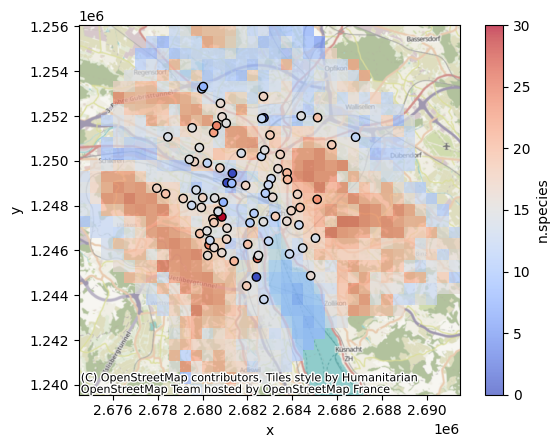

In [ ]:
model_class = linear_model.LinearRegression
urban_model = model_class().fit(urban_fa.features_df, y_ser)
urban_pred_da = urban_fa.predict_raster(
    urban_model,
    study_area_filepath,
    grid_res,
    pred_label=y_ser.name,
)
plot_da_and_gdf(urban_pred_da, bird_gdf, y_ser)

We can actually plot both maps side-by-side with a common color scale:

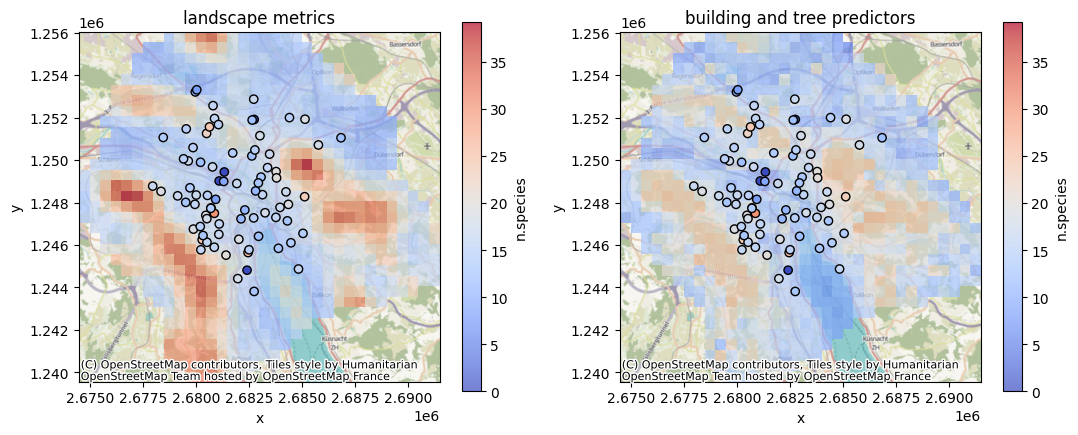

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(figwidth * 2, figheight))
vmin = min(pred_da.min().item(), urban_pred_da.min().item(), y_ser.min())
vmax = max(pred_da.max().item(), urban_pred_da.max().item(), y_ser.max())
for ax, da, title in zip(
    axes,
    [pred_da, urban_pred_da],
    ["Landscape metrics", "Building and tree predictors"],
):
    plot_da_and_gdf(da, bird_gdf, y_ser, ax=ax, vmin=vmin, vmax=vmax)
    ax.set_title(title)

It seems that using the surrounding building volumes and the tree canopy amounts result in a smoother species richness map than its landscape metrics-based counterpart (which is likely in line with the discrete nature of LULC categories).

Finally, note that we can use cross-validation to select any model other than a linear regression:

In [ ]:
# compare models using 3-fold cross-validation
model_class_dict = {
    "Linear regression": linear_model.LinearRegression(),
    "Gradient boosting": ensemble.GradientBoostingRegressor(),
    "Random forest": ensemble.RandomForestRegressor(),
}
for name, model in model_class_dict.items():
    scores = cross_val_score(
        model,
        X_urban_df,
        y_ser,
        cv=3,
        scoring=lambda est, X, y: stats.pearsonr(y, est.predict(X))[0] ** 2,
    )
    print(f"{name}: mean R2 = {scores.mean():.3f} (+/- {scores.std():.3f})")

Linear regression: mean R2 = 0.167 (+/- 0.135)
Gradient boosting: mean R2 = 0.098 (+/- 0.106)
Random forest: mean R2 = 0.130 (+/- 0.102)


Nonetheless it seems that the linear regression shows the most robust performance for this relationship.